# Centrality

In this section, I'm going to learn how Centrality works and try to interpret the data based on small real dataset. I'm using Facebook DataSet from SNAP https://snap.stanford.edu/data/egonets-Facebook.html. The data is included in this repository for easier access. The data is in EdgeList format (source, target).

In [19]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import operator
import timeit

In [20]:
g_fb = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)

In [21]:
print nx.info(g_fb)
print nx.is_directed(g_fb)

Name: 
Type: Graph
Number of nodes: 4039
Number of edges: 88234
Average degree:  43.6910
False


In [22]:
spring_pos = nx.spring_layout(g_fb)

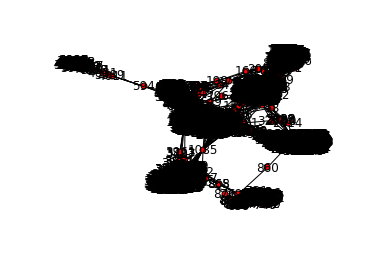

In [16]:
plt.axis('off')
nx.draw_networkx(g_fb, pos = spring_pos, with_lables=False, node_size = 35)

Now let's find the celebrities. The most basic centrality is Degree Centrality which is the sum of all in and out nodes (in the case of directed graph). 

In [23]:
dg_centrality = nx.degree_centrality(g_fb)
sorted_dg_centrality = sorted(dg_centrality.items(), key=operator.itemgetter(1), reverse=True)
sorted_dg_centrality[:10]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317),
 (1800, 0.06067360079247152),
 (1663, 0.058197127290737984)]

We can see that the node 107 has the highest degree centrality which means node 107 has the highest number of connected nodes. We can prove this by getting the degree of node 107 to see how many friends of node 107 has

In [24]:
nx.degree(g_fb, [107])

{107: 1045}

Node 107 has 1045 friends and we can divide that by number of nodes to get the normalized degree centrality

In [25]:
float(nx.degree(g_fb, [107]).values()[0]) / g_fb.number_of_nodes()

0.25872740777420156

Degree centrality might be the easiest number to calculate but it only shows the number of nodes connected which in real social network it might not be very useful as you might have a million followers but if the majority of them is bots then the number is not telling anything new.

Now let's try Betweenness which count all of the shortest path going throw each now. This might mean that if you have the highest shortest path going through you, you might be considered as bridge of your entire network.

Nodes with high betweenness are important in communication and information diffusion

We will be using multiprocessing so we can parallel the computation and distribute the load.

In [26]:
from multiprocessing import Pool  
import itertools

In [27]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [28]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [29]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

Let's try with multiprocesser.

It takes 124.432162046 seconds to finish
[(107, 0.4805180785560148), (1684, 0.3377974497301947), (3437, 0.23611535735892855), (1912, 0.22929533958687467), (1085, 0.14901509211665434), (0, 0.1463059214744287), (698, 0.11533045020561015), (567, 0.09631033121856315), (58, 0.0843602059079655), (428, 0.0643090623932384)]


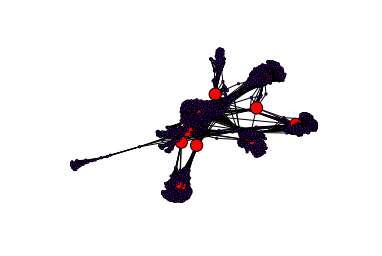

In [31]:
start = timeit.default_timer()
bt = between_parallel(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

Now let's try with just one processor

It takes 229.852290154 seconds to finish
[(107, 0.48051807855601475), (1684, 0.3377974497302), (3437, 0.23611535735892797), (1912, 0.2292953395868785), (1085, 0.14901509211665198), (0, 0.14630592147442847), (698, 0.11533045020560787), (567, 0.09631033121856226), (58, 0.08436020590796657), (428, 0.0643090623932386)]


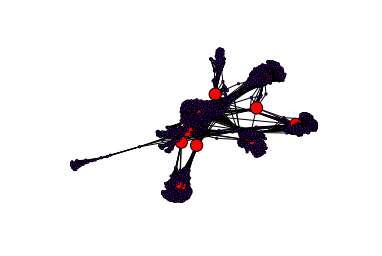

In [32]:
start = timeit.default_timer()
bt = nx.betweenness_centrality(g_fb)
stop = timeit.default_timer()
top = 10

max_nodes =  sorted(bt.iteritems(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(g_fb.nodes())
bt_colors = [0]*len(g_fb.nodes())
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(g_fb, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

print 'It takes {} seconds to finish'.format(stop - start)
print max_nodes

We would like to try Closenese Centrality. The number shows how close are you to the entire network. It's very similar to Betweenness Centrality

In [42]:
start = timeit.default_timer()
cs = nx.closeness_centrality (g_fb)
stop = timeit.default_timer()
top = 10

max_cn_nodes =  sorted(cs.iteritems(), key = lambda v: -v[1])[:top]
print 'It takes {} seconds to finish'.format(stop - start)
print max_cn_nodes

It takes 93.5353550911 seconds to finish
[(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509), (563, 0.3939127889961955), (1684, 0.39360561458231796), (171, 0.37049270575282134), (348, 0.36991572004397216), (483, 0.3698479575013739), (414, 0.3695433330282786), (376, 0.36655773420479304)]


#Page rank

We're going to try PageRank algorithm. This is very similar to Google's PageRank which they use incoming links to determine the "popularity"

In [33]:
g_fb_pr = nx.pagerank(g_fb)

In [34]:
top = 10
max_pagerank = sorted(g_fb_pr.iteritems(), key = lambda v: -v[1])[:top]
max_pagerank

[(3437, 0.007614586844749602),
 (107, 0.006936420955866113),
 (1684, 0.006367162138306825),
 (0, 0.006289602618466542),
 (1912, 0.0038769716008844957),
 (348, 0.002348096972780577),
 (686, 0.0022193592598000193),
 (3980, 0.0021703235790099928),
 (414, 0.0018002990470702264),
 (698, 0.0013171153138368812)]

We can see that now the score is different as node 3437 is more popular than node 107.

# Who is a "Gray Cardinal"
There's another metric that we can measure most influential node. It's called eigenvector centrality. To put it simply it means that if you're well connected to a lot of important people that means you're important or most influential as well. 

In [35]:
g_fb_eg = nx.eigenvector_centrality(g_fb)

In [36]:
top = 10
max_eg = sorted(g_fb_eg.iteritems(), key = lambda v: -v[1])[:top]
max_eg

[(1912, 0.09540688873596533),
 (2266, 0.08698328226321961),
 (2206, 0.08605240174265634),
 (2233, 0.08517341350597848),
 (2464, 0.0842787836468596),
 (2142, 0.08419312450068117),
 (2218, 0.08415574433673877),
 (2078, 0.08413617905810125),
 (2123, 0.08367142125897375),
 (1993, 0.08353243711860492)]

Now we get quite a different result. This would mean that node 1912 is connected to more important people in the entire network that means that node is more influential than the rest of the network.

# iGraph with SNAP Facebook Dataset
Networkx is easy to install and great to start with. However, as it's written in Python it's quite slow. I'm going to try iGraph which is C based. I'm hoping that this would yield the same result but faster.

In [37]:
from igraph import *

In [38]:
igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

In [39]:
print igraph_fb.summary()

IGRAPH U--- 4039 88234 -- 


##Betweenness

In [40]:
def betweenness_centralization(G):
    vnum = G.vcount()
    if vnum < 3:
        raise ValueError("graph must have at least three vertices")
    denom = (vnum-1)*(vnum-2)
 
    temparr = [2*i/denom for i in G.betweenness()]
    return temparr

In [41]:
start = timeit.default_timer()
igraph_betweenness = betweenness_centralization(igraph_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 5.89585280418 seconds to finish


In [55]:
igraph_betweenness.sort(reverse=True)
print igraph_betweenness[:10]

[0.4805180785560146, 0.3377974497302, 0.23611535735892794, 0.22929533958687848, 0.14901509211665237, 0.14630592147442847, 0.11533045020560788, 0.09631033121856228, 0.08436020590796657, 0.0643090623932386]


##Closeness

In [56]:
start = timeit.default_timer()
igraph_closeness = igraph_fb.closeness()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 6.03449511528 seconds to finish
[0.45969945355191255, 0.3974018305284913, 0.3948371956585509, 0.3939127889961955, 0.39360561458231796, 0.37049270575282134, 0.36991572004397216, 0.3698479575013739, 0.3695433330282786, 0.36655773420479304]


In [59]:
igraph_closeness.sort(reverse=True)
print igraph_closeness[:10]

[0.45969945355191255, 0.3974018305284913, 0.3948371956585509, 0.3939127889961955, 0.39360561458231796, 0.37049270575282134, 0.36991572004397216, 0.3698479575013739, 0.3695433330282786, 0.36655773420479304]


## EigenValue

In [63]:
start = timeit.default_timer()
igraph_eg = igraph_fb.evcent()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0605199337006 seconds to finish


In [64]:
igraph_eg.sort(reverse=True)
print igraph_eg[:10]

[1.0, 0.9117190175727692, 0.9019626322184224, 0.8927488203018574, 0.8833723691600276, 0.8824740496738565, 0.8820826938160453, 0.8818776189568697, 0.8770062766705495, 0.8755494858467853]


## PageRank

In [65]:
start = timeit.default_timer()
igraph_pr = igraph_fb.pagerank()
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0709159374237 seconds to finish


In [66]:
igraph_pr.sort(reverse=True)
print igraph_pr[:10]

[0.0075745665246258935, 0.006888375869731625, 0.0063084887921967805, 0.0062246948047383005, 0.0038165503710367713, 0.002317366308283276, 0.002216791818397391, 0.002156551114912813, 0.0017822888082657136, 0.00129416751155367]


We can see that iGraph yields similar result from networkx but it's a lot quicker in the same machine.

# Graph_tool with SNAP Facebook Dataset
I'm going to try another library which is supposed to be the fastest than networkx and igraph. Graph_tool is also C based which it has OpenMP enabled so a lot of algorithms is multiprocessing. 

In [67]:
import sys
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *
import timeit

In [68]:
show_config()

version: 2.2.44 (commit 178add3a, Thu Jul 2 01:44:54 2015 +0200)
gcc version: 4.8.2
compilation flags: -D_FORTIFY_SOURCE=2 -I/usr/include/python2.7 -I/usr/include -I/usr/lib/python2.7/dist-packages/numpy/core/include -I/usr/lib/python2.7/dist-packages/scipy -I/usr/include -DSPARSEHASH_PREFIX=google -Wall -Wextra -ftemplate-backtrace-limit=0 -O3 -DNDEBUG -std=gnu++11 -ftemplate-depth-250 -Wno-deprecated -Wno-unknown-pragmas -O3 -fvisibility=default -fvisibility-inlines-hidden -fopenmp -I/usr/include -DSPARSEHASH_PREFIX=google -Wl,-Bsymbolic-functions -Wl,-z,relro -L/usr/lib -lpython2.7
install prefix: /usr
python dir: /usr/lib/python2.7/dist-packages
graph filtering: True
openmp: True
uname: Linux ip-172-31-45-186 3.13.0-48-generic #80-Ubuntu SMP Thu Mar 12 11:16:15 UTC 2015 x86_64


In [69]:
graph_tool_fb = Graph(directed=False)

In [70]:
edges = []
with open('facebook_combined.txt', 'r') as f:
    for line in f:
        edge_list = line.split()
        source, target = tuple(edge_list)
        graph_tool_fb.add_edge(source, target)

In [71]:
print graph_tool_fb.num_vertices()
print graph_tool_fb.num_edges()

4039
88234


## Betweeness

In [74]:
start = timeit.default_timer()
vertext_betweenness, edge_betweenness = betweenness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 7.47633004189 seconds to finish


In [75]:
vertext_betweenness.a[107]

0.48051807855601453

## Closeness

In [77]:
start = timeit.default_timer()
v_closeness = closeness(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 7.69668292999 seconds to finish


In [78]:
v_closeness.a[107]

0.45969945355191255

## Eigenvalue

In [79]:
start = timeit.default_timer()
v_closeness = eigenvector(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0300698280334 seconds to finish


## Page Rank

In [80]:
start = timeit.default_timer()
v_closeness = pagerank(graph_tool_fb)
stop = timeit.default_timer()
print 'It takes {} seconds to finish'.format(stop - start)

It takes 0.0744159221649 seconds to finish


#Conclusion

Both igraph and graph_tool yield similar performance. So, for the real data I'm going to use graph_tool as the documentation is more comprehensive.

# Real data
The data we collect from Twitter Streaming API is stored in Mongodb.

In [81]:
%matplotlib inline
import pymongo
import networkx as nx
import time
import itertools
import operator

from multiprocessing import Pool
from pymongo import MongoClient

from sweepy.get_config import get_config

config = get_config()

MONGO_URL = config.get('MONGO_URL')
MONGO_PORT = config.get('MONGO_PORT')
MONGO_USERNAME = config.get('MONGO_USERNAME')
MONGO_PASSWORD = config.get('MONGO_PASSWORD')
MONGO_DATABASE = config.get('MONGO_DATABASE')

client = MongoClient(MONGO_URL, int(MONGO_PORT))

db = client[MONGO_DATABASE]
db.authenticate(MONGO_USERNAME, MONGO_PASSWORD)

users = db.users
raw_tweets = db.raw_tweets

Let's do some data exploration first.

## Who retweet the most in Fusion network

In [88]:
most_retweets = raw_tweets.aggregate([
    { '$group' : { '_id': '$user.id_str', 'count' : { '$sum' : 1 } } },
    { '$match' : { 'count' : { '$gte' : 1 } } },
    { '$sort' : { 'count' : -1 } },
    { '$limit' : 10}
])

In [91]:
for most_retweet in most_retweets:
    print most_retweet

{u'count': 1420, u'_id': u'121817564'}
{u'count': 421, u'_id': u'3106528812'}
{u'count': 247, u'_id': u'220038215'}
{u'count': 100, u'_id': u'3152407786'}
{u'count': 76, u'_id': u'7154912'}
{u'count': 59, u'_id': u'151938942'}
{u'count': 52, u'_id': u'34294546'}
{u'count': 47, u'_id': u'3152728781'}
{u'count': 45, u'_id': u'789920724'}
{u'count': 40, u'_id': u'200249089'}


In [ ]:
all_users = users.find({}, { 'id' : 1, 'friends_ids' : 1}).batch_size(50)

We are going to convert the data to edgelist so it's easier to import to various different tools

In [8]:
with open('twitter_edgelist.txt', 'w') as f:
    for user in all_users:
        u_id = str(abs(user['id']))
        for friend_id in user['friends_ids']:
            f_id = str(abs(friend_id))
            f.write('{} {}\n'.format(u_id, f_id))

In [ ]:
twitter_networkx = nx.read_edgelist('twitter_edgelist.txt', create_using = nx.Graph(), nodetype = int)

In [15]:
print nx.info(twitter_networkx)

Name: 
Type: Graph
Number of nodes: 2857190
Number of edges: 6721557
Average degree:   4.7050


In [4]:
print nx.info(graph)

Name: 
Type: DiGraph
Number of nodes: 2432155
Number of edges: 5278690
Average in degree:   2.1704
Average out degree:   2.1704


In [4]:
eigen_values = nx.eigenvector_centrality(graph)

In [10]:
sorted_eigen_values = sorted(eigen_values.items(), key=operator.itemgetter(1), reverse=True)
sorted_eigen_values[:10]

[('121817564', 0.09428345177961117),
 ('11107172', 0.07497270265786563),
 ('807095', 0.06812954689012012),
 ('216695058', 0.06667872003411948),
 ('20861943', 0.06605647185989534),
 ('58524428', 0.06489206418816294),
 ('16104258', 0.06282196653973698),
 ('18816166', 0.06144353212620821),
 ('436873679', 0.05926741271555719),
 ('14677919', 0.0592280032725243)]

In [ ]:
closeness_values = nx.closeness_centrality(graph)

In [ ]:
sorted_closeness_values = sorted(closeness_values.items(), key=operator.itemgetter(1), reverse=True)
sorted_closeness_values[:10]

#iGraph

In [11]:
from igraph import *

In [12]:
twitter_igraph = Graph.Read_Ncol('twitter_edgelist.txt', directed=True)

In [14]:
print twitter_igraph.summary()

IGRAPH DN-- 2869228 6764984 -- 
+ attr: name (v)


In [16]:
thisisfusion = twitter_igraph.vs.find(name='121817564')
thisisfusion.degree(type="out")

1907

In [18]:
twitter_igraph.betweenness(cutoff=5000)

KeyboardInterrupt: 

# Graph tool

In [3]:
import sys
import os
sys.path.append('/usr/lib/python2.7/dist-packages')

from graph_tool.all import *

In [18]:
g = Graph()
all_users = users.find({}, { 'id_str' : 1, 'friends_ids' : 1}).batch_size(50)
vprop_string = g.new_vertex_property('string')

In [16]:
v = g.add_vertex()
vprop_string[v] = 'id'

In [ ]:
find_vertex(g, g.vertex_properties[''])

In [19]:
print 'Processing first 1000 batch'
for idx, user in enumerate(all_users):
    if idx and not idx % 1000:
        print 'Processing {} batch'.format(idx)
        
    u_id = str(user['id_str'])
    v = g.add_vertex(1)
    
    for friend_id in user['friends_ids']:
        f_id = str(friend_id)
        f = g.add_vertex(1)
        g.add_edge(v, f)

Processing first 1000 batch
Processing 1000 batch
Processing 2000 batch
Processing 3000 batch
Processing 4000 batch
Processing 5000 batch


In [ ]:
graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=12, output_size=(1000, 1000))

10
